In [1]:
import pandas as pd
from collections import defaultdict
import pysam
import pathlib
import json
import numpy as np
import seaborn as sns
import anndata
from ALLCools.plot import *

import matplotlib.pyplot as plt
from scipy.stats import poisson
from statsmodels.stats.multitest import multipletests
from concurrent.futures import ProcessPoolExecutor, as_completed

In [2]:
def _calculate_cell_record(allc_path, output_path, resolution=100):
    allc_path = str(allc_path)
    output_path = str(output_path)

    cell_records = {}
    i = 0
    with pysam.TabixFile(allc_path) as allc:
        for i, line in enumerate(allc.fetch()):
            chrom, pos, *_, cov, _ = line.split('\t')
            if int(cov) > 2:
                # some site have cov even > 4, but it should be fine,
                # if it is due to repeat mapping, will occur in most of the cells.
                bin_id = int(pos) // resolution
                try:
                    cell_records[chrom][bin_id] += 1
                except KeyError:
                    cell_records[chrom] = defaultdict(int)
                    cell_records[chrom][bin_id] += 1

    cell_total_c = i + 1
    cell_records = {
        chrom: list(values.keys())
        for chrom, values in cell_records.items()
    }
    # final output to disk
    total_records = {'total_c': cell_total_c, 'bins': cell_records}

    with open(output_path, 'w') as f:
        json.dump(total_records, f)
    return output_path


def quantify_cells(allc_paths, resolution, cpu=1):
    tmp_dir = pathlib.Path('rmdl_temp_dir')
    tmp_dir.mkdir(exist_ok=True)

    region_records = {}
    with ProcessPoolExecutor(cpu) as exe:
        futures = []
        for path in allc_paths:
            output_path = tmp_dir / pathlib.Path(path).name
            future = exe.submit(_calculate_cell_record,
                                allc_path=path,
                                output_path=output_path,
                                resolution=resolution)
            futures.append(future)

        # during calculating the cell records, also summarize region records
        for future in as_completed(futures):
            output_path = future.result()
            with open(output_path) as f:
                cell_record = json.load(f)
                for chrom, chrom_bins in cell_record['bins'].items():
                    if chrom not in region_records:
                        region_records[chrom] = defaultdict(int)
                    for bin_id in chrom_bins:
                        region_records[chrom][bin_id] += 1

    # final output to disk
    with open('rmdl_temp_dir/region_records', 'w') as f:
        json.dump(region_records, f)
    return region_records


def calculate_blacklist_region(region_records):
    # calculate region poisson mu
    sum_of_bin = 0
    n_bin = 0
    for chrom, chrom_values in region_records.items():
        sum_of_bin += sum(chrom_values.values())
        n_bin += len(chrom_values)
    mu = sum_of_bin / n_bin
    
    # calculate region FDR p cutoff
    total_p = []
    for chrom, chrom_values in region_records.items():
        chrom_values = pd.Series(chrom_values)
        p_values = poisson.sf(chrom_values.values, mu)
        total_p.append(p_values)
    total_p = np.concatenate(total_p)
    judge, *_ = multipletests(total_p, alpha=0.01, method='fdr_bh')
    p_max = total_p[judge].max()
    del total_p, judge
    
    # calculate region blacklist
    final_blacklist = {}
    for chrom, chrom_values in region_records.items():
        chrom_values = pd.Series(chrom_values)
        p_values = poisson.sf(chrom_values.values, mu)
        final_blacklist[chrom] = list(chrom_values[p_values < p_max].index)
    return final_blacklist

In [3]:
allc_paths = list(
    pathlib.Path('/home/hanliu/cemba3c/MOp1/').glob('*/allc/*tsv.gz'))
resolution = 100
cpu = 48

In [34]:
allc_paths = pd.read_csv('doublets_allc.txt', index_col=None, header=None, squeeze=True).tolist()

In [5]:
print(len(allc_paths))

2183


In [ ]:
region_records = quantify_cells(allc_paths, resolution, cpu=48)

In [6]:
def calculate_cell_values(output_path):
    with open(output_path) as f:
        cell_record = json.load(f)
        total_bins = 0
        total_n = 0
        for chrom, bins in cell_record['bins'].items():
            total_bins += len(bins)
            total_n += len(set(bins) - region_blacklist[chrom])
        cell_values = {
            'total_n': total_n,
            'total_bins': total_bins,
            'total_c': cell_record['total_c']
        }
    return cell_values

In [8]:
with open('mm10_blacklist.100.json') as f:
    region_blacklist = json.load(f)
region_blacklist = {k: set(v) for k, v in region_blacklist.items()}

In [11]:
total_values = {}
for i, path in enumerate(pathlib.Path('rmdl_temp_dir/').glob('*.gz')):
    file_name = pathlib.Path(path).name
    output_path = f'rmdl_temp_dir/{file_name}'
    cell_id = file_name.split('.')[0]
    total_values[cell_id] = calculate_cell_values(output_path)
    if i % 500 == 0:
        print(i, end=' ')

0 500 1000 1500 2000 2500 3000 

In [12]:
total_values = pd.DataFrame(total_values).T
total_values.head()

,total_n,total_bins,total_c
CEMBA3C_MOp2C_R1_P1-1-F3-I13,9743,11497,17452918
CEMBA3C_MOp2C_R1_P1-1-F3-A14,10186,12069,15936936
CEMBA3C_MOp2C_R1_P1-1-F3-B1,11430,13439,16637944
CEMBA3C_MOp2C_R1_P1-1-F3-H13,11358,13337,17886811
CEMBA3C_MOp2C_R1_P1-1-F3-C1,10850,12807,18383057


In [13]:
total_values['ratio'] = total_values['total_n'] / total_values['total_c'] * 10000
total_values['ratio'].describe()

count    3355.000000
mean       11.032695
std         4.325230
min         0.000000
25%         8.729022
50%        11.553905
75%        13.226646
max        25.790799
Name: ratio, dtype: float64

<AxesSubplot:xlabel='total_c', ylabel='ratio'>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


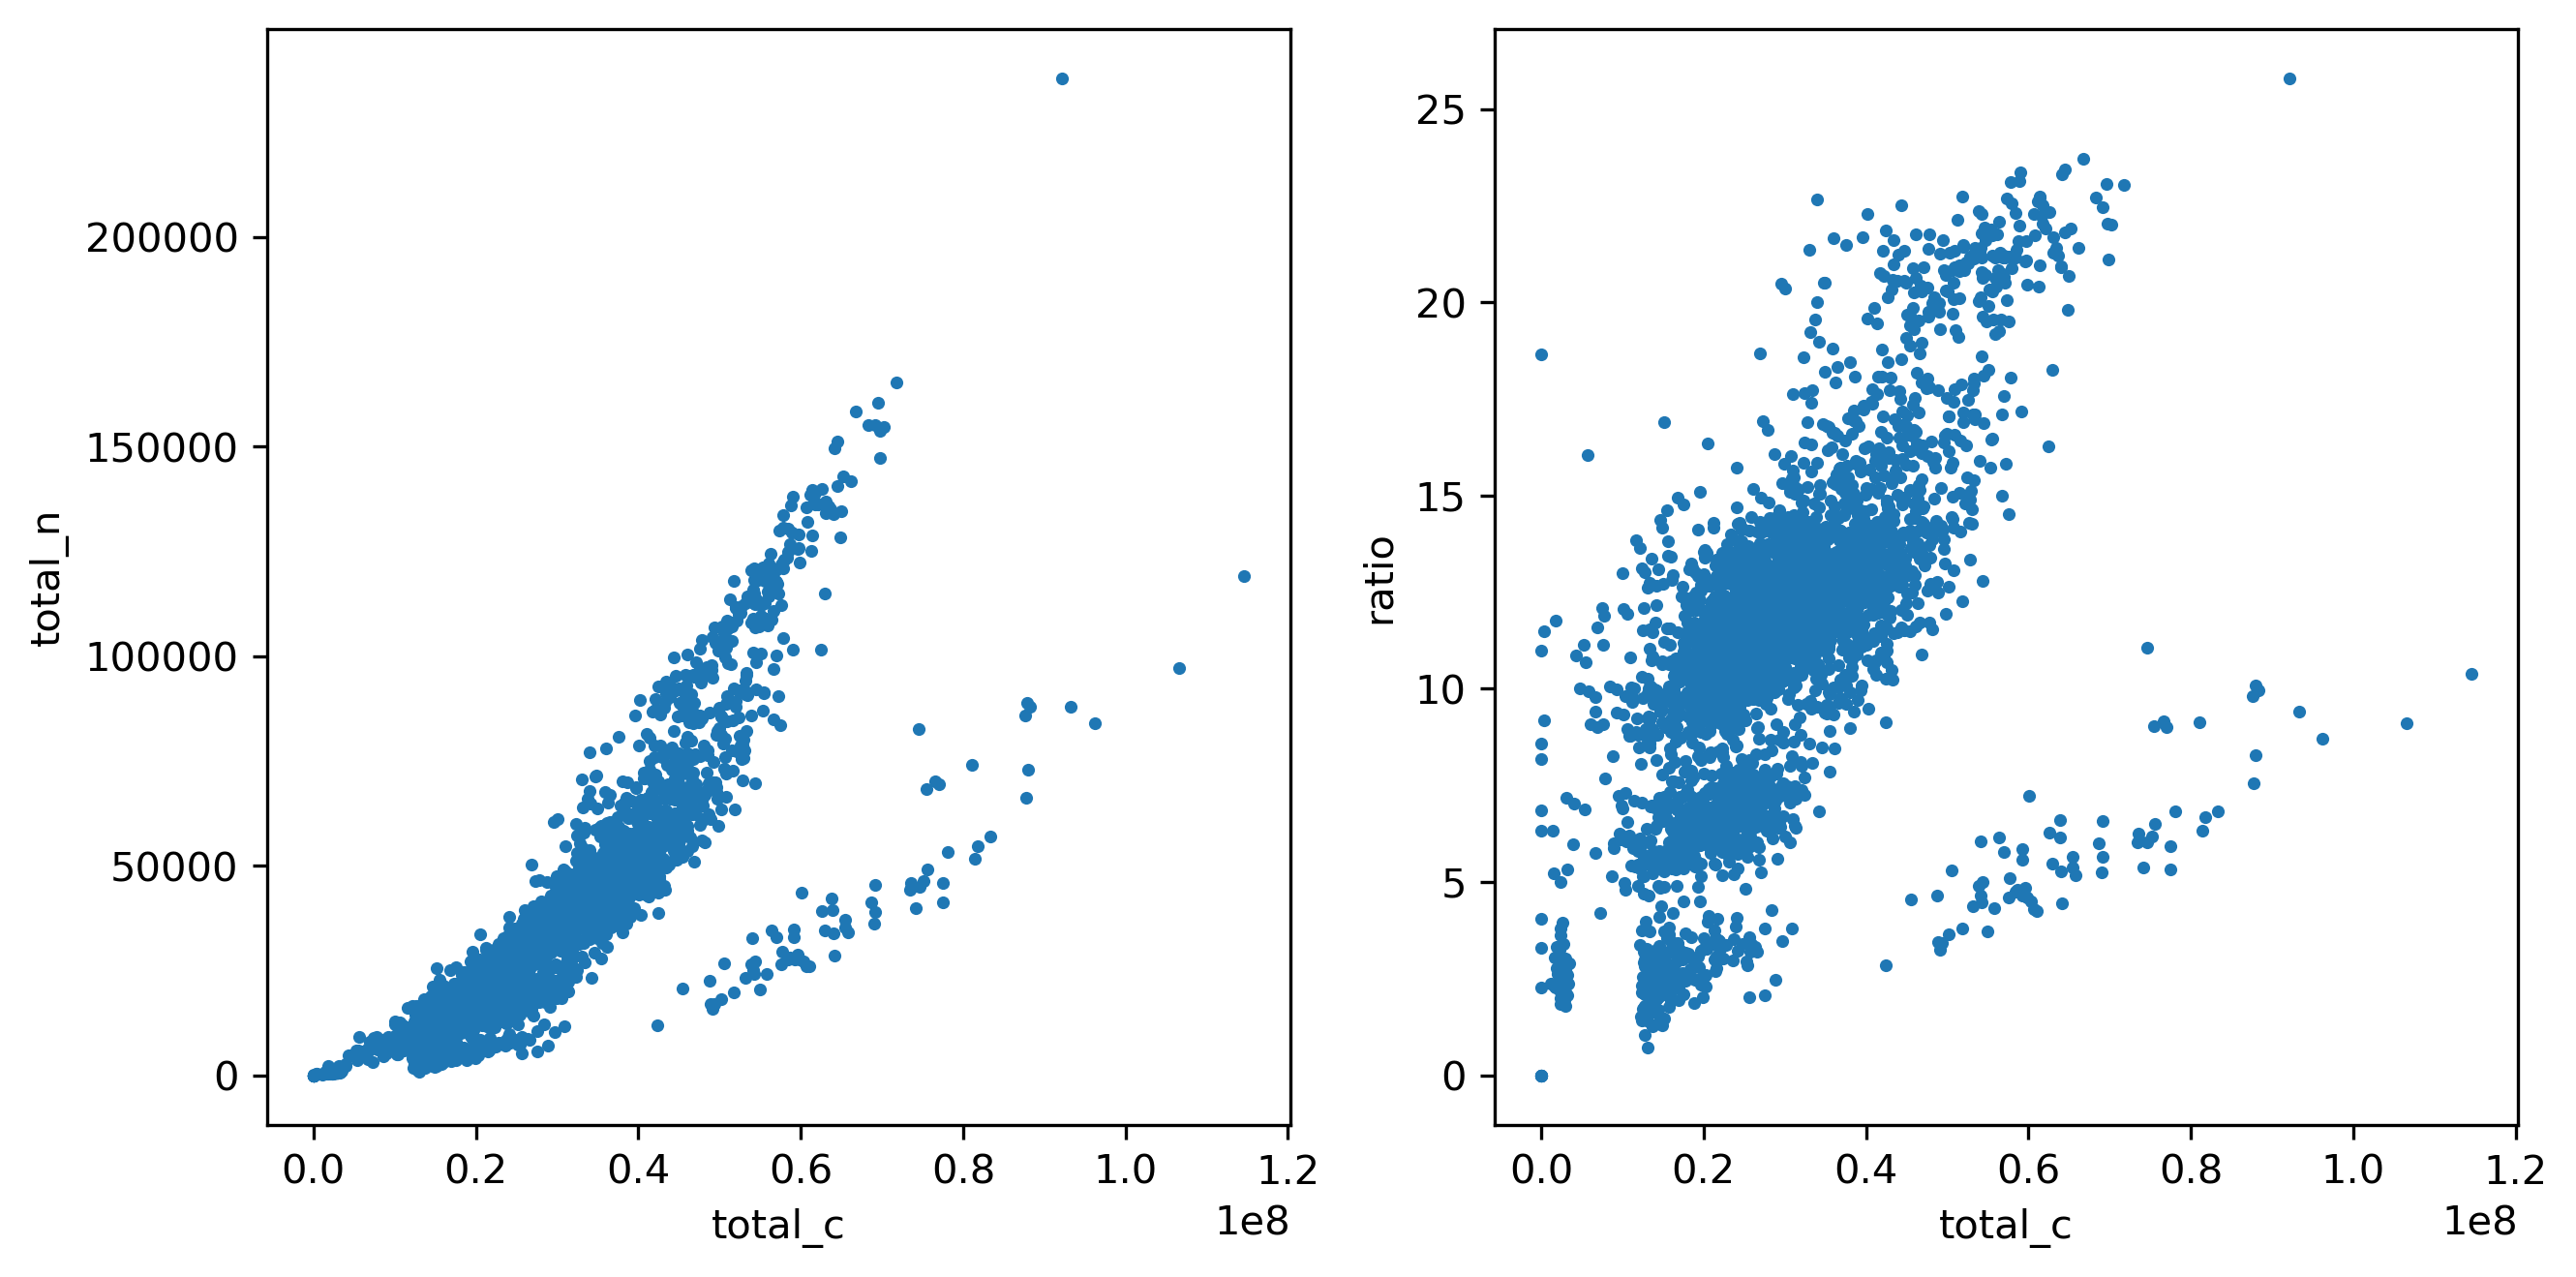

In [14]:
fig, axes = plt.subplots(figsize=(10, 5), dpi=300, ncols=2)
ax = axes[0]
sns.scatterplot(data=total_values, x='total_c', y='total_n', s=10, linewidth=0, ax=ax)
ax = axes[1]
sns.scatterplot(data=total_values, x='total_c', y='ratio', s=10, linewidth=0, ax=ax)

In [15]:
(total_values['ratio'] > 17).sum() / total_values.shape[0]

0.07242921013412816

In [29]:
total_values.shape

(3355, 4)

In [17]:
total_adata = anndata.read_h5ad(
    '/home/hanliu/project/cemba/study/Clustering/MethylomeEnsembl/L1/adata.with_coords.h5ad'
)

In [18]:
total_cell_meta = pd.read_hdf(
    '/home/hanliu/project/cemba/study/Clustering/MethylomeEnsembl/L1/CellMetadata.PassQC.hdf'
)

In [19]:
plate_fc = total_cell_meta.groupby('Plate').apply(lambda i: i['FinalmCReads'] / i['FinalmCReads'].median())
plate_fc.index = plate_fc.index.droplevel(0)
total_adata.obs['plate_fc'] = np.log2(plate_fc)

In [36]:
allc_paths = pd.read_hdf('/home/hanliu/project/cemba/metainfo/CellMetadata.324687.2021-09-13.hdf')

In [41]:
name_to_id = {
    v: k
    for k, v in allc_paths['AllcPath'].apply(
        lambda i: i.split('/')[-1].split('.')[0]).items()
}
total_values.index = total_values.index.map(lambda i: name_to_id[i]
                                            if i in name_to_id else i)

In [45]:
plot_cells = total_adata.obs.loc[total_adata.obs_names.isin(total_values.index)].copy()
plot_cells['ratio'] = total_values['ratio']
plot_cells['tsne_0'] = total_adata.obs['tsne_0']
plot_cells['tsne_1'] = total_adata.obs['tsne_1']

In [46]:
plot_cells.shape

(3243, 12)

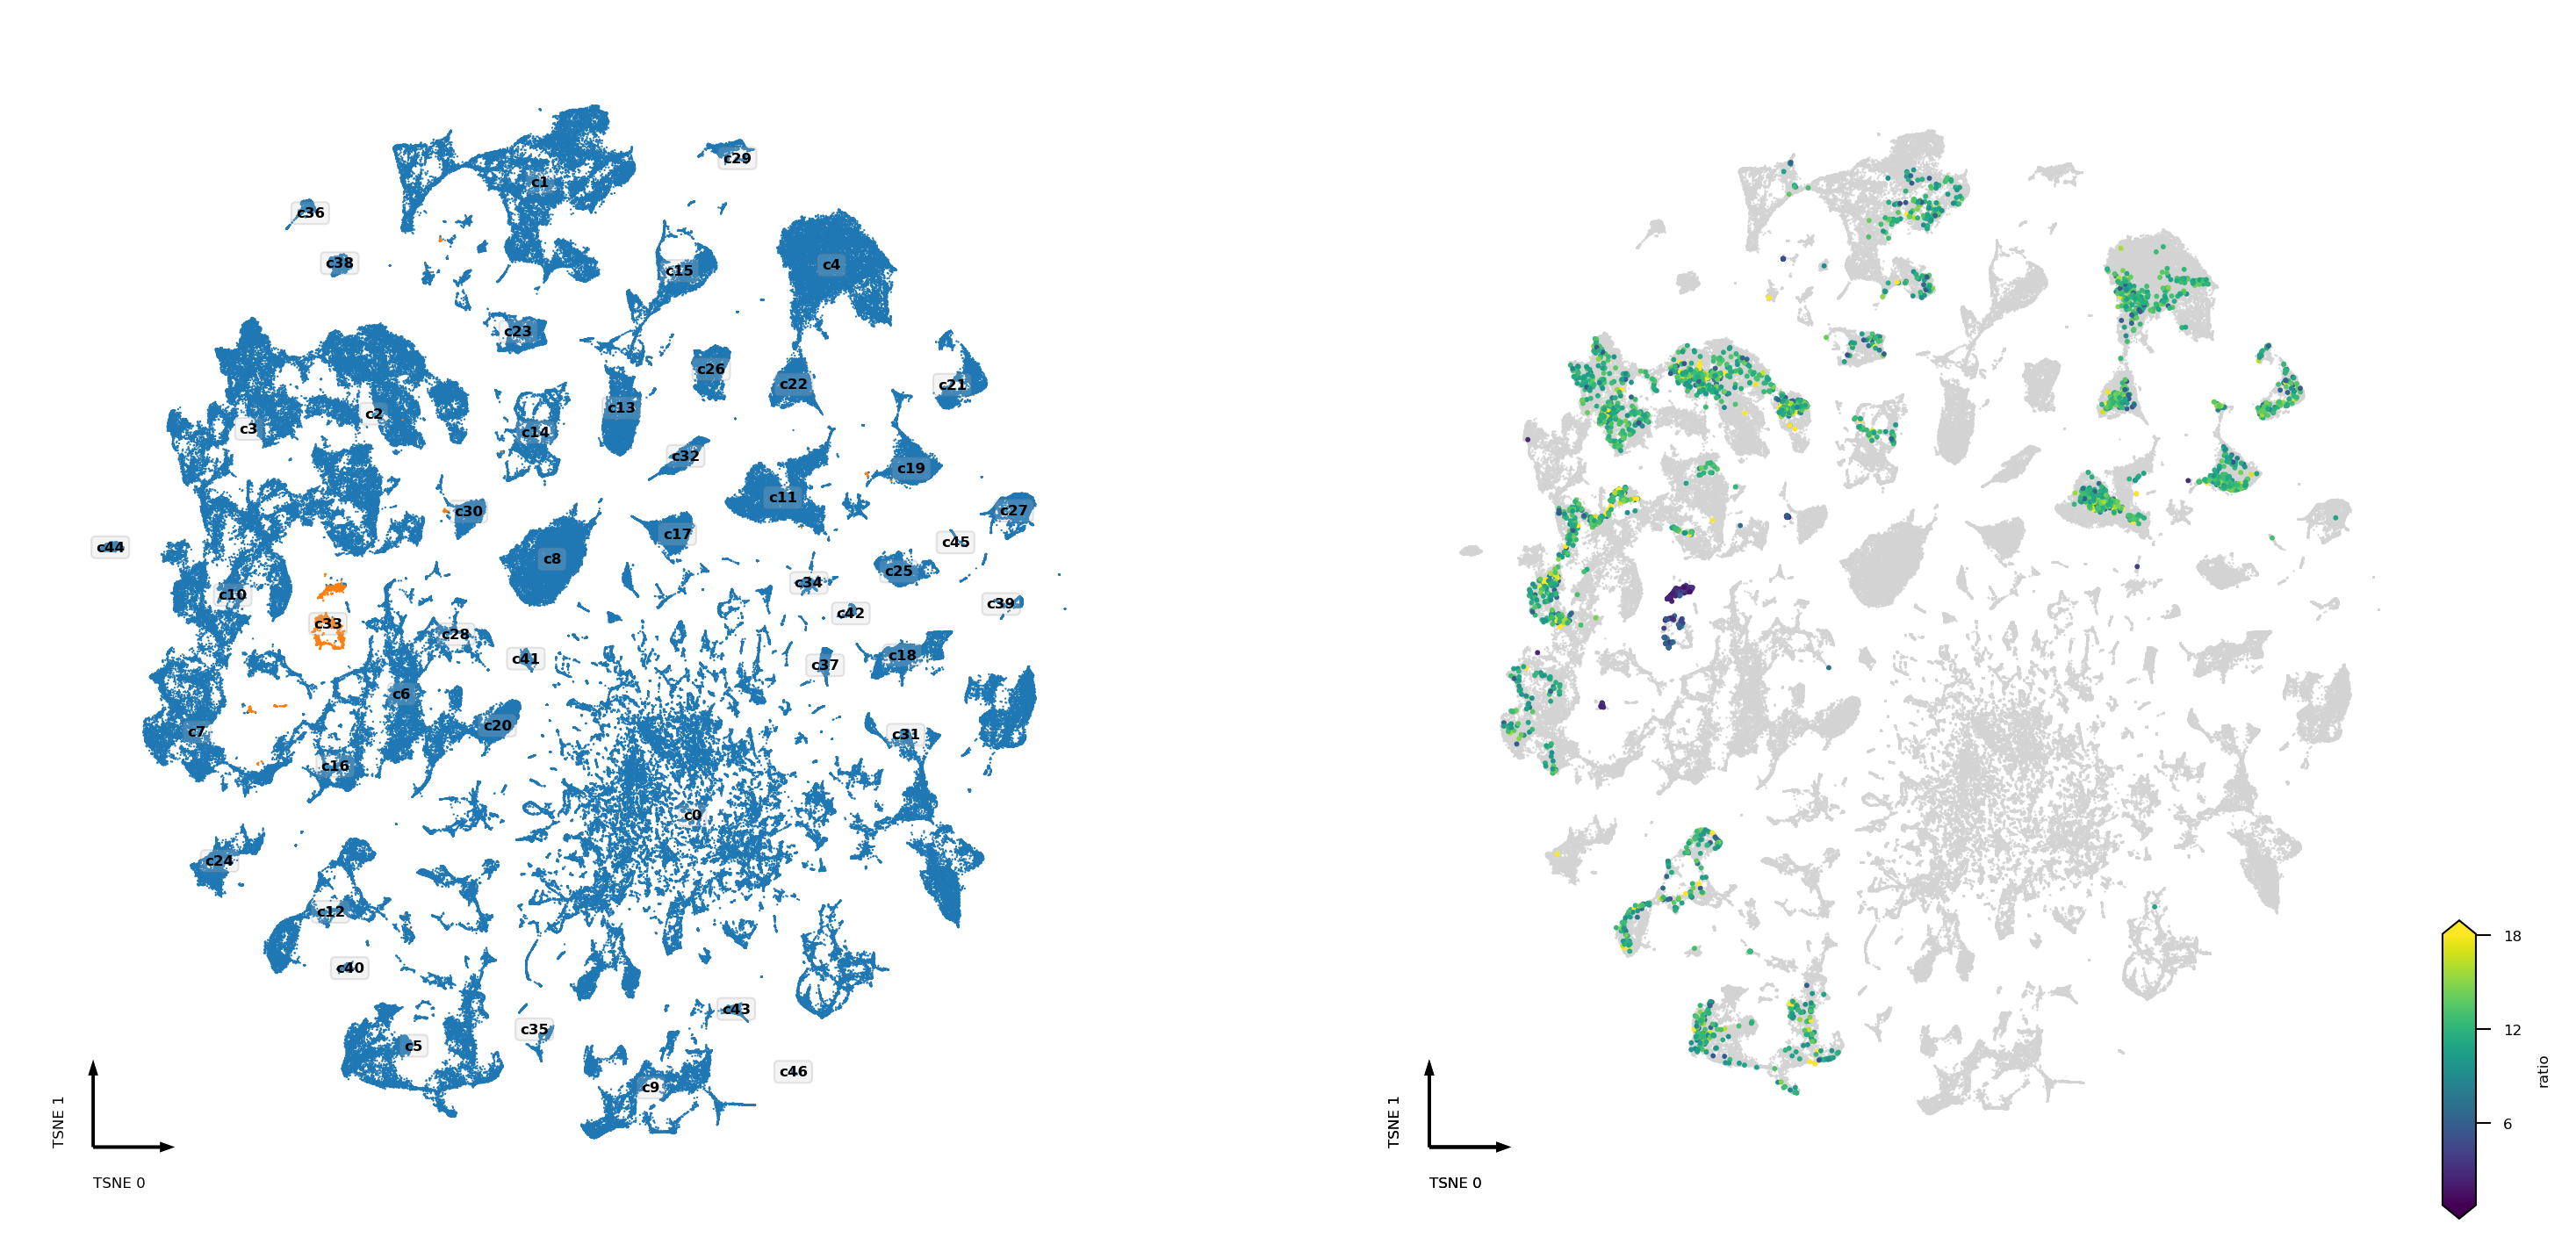

In [47]:
fig, axes = plt.subplots(figsize=(12, 6), dpi=300, ncols=2, nrows=1)
ax = axes[0]
categorical_scatter(data=total_adata,
                    coord_base='tsne',
                    ax=ax,
                    hue=total_adata.obs['L1'] == 'c33',
                    text_anno='L1',
                    s=0.3,
                    max_points=None)
ax = axes[1]
categorical_scatter(data=total_adata,
                    coord_base='tsne',
                    ax=ax,
                    scatter_kws=dict(color='lightgray'),
                    s=0.3,
                    max_points=None)
continuous_scatter(data=plot_cells,
                    coord_base='tsne',
                    ax=ax,
                    hue='ratio',
                    s=2)